In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/turkish-sentiment-analysis-data-beyazperdecom/test.csv
/kaggle/input/turkish-sentiment-analysis-data-beyazperdecom/train.csv


In this notebook, I am going to classify Turkish film comments shared in beyazperde.com with the help of [BERTurk pretrained language model](https://github.com/stefan-it/turkish-bert) using PyTorch and Huggingface Transformers library.

*In order to speed up the training process, I recommend to use GPU provided by Kaggle.*

Set device type as CUDA to utilize GPU:

In [2]:
import torch
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

We will use the GPU: Tesla P100-PCIE-16GB


# 1) Exploratory Data Analysis

In [3]:
df_train=pd.read_csv("/kaggle/input/turkish-sentiment-analysis-data-beyazperdecom/train.csv",index_col=[0],encoding="windows-1252")
df_test=pd.read_csv("/kaggle/input/turkish-sentiment-analysis-data-beyazperdecom/test.csv",index_col=[0],encoding="windows-1252")

In [4]:
df_train.head()

,comment,Label
0,biri bana bu filmde benim anlamadigim bisey ol...,0
1,ya çocuklar ilk filmin sonunda büyüdüler ya bu...,1
2,film biraz daha uzun sürse harbi kiyameti göre...,0
3,pek orjinal bi cinayet yok ama orjinal oyuncul...,0
4,film tek kelimeyle muhtesemdi heleki sonundaki...,1


In [5]:
df_train["Label"].value_counts()

1    3998
0    3998
Name: Label, dtype: int64

In [6]:
df_train.isna().sum()

comment    0
Label      0
dtype: int64

* The dataset is highly balanced. 
* There is no missing value.

## Unigram and Bigram Distributions in Each Class

To understand the dataset, let's have a look at the common top-15 unigrams and bigrams' frequencies for each class. To generate them, we need to tokenize each comments by using **nltk** library.

### **POSITIVE CLASS UNIGRAMS**

In [7]:
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
stop_words=stopwords.words("turkish")
stop_words.extend(["bir","film","filmi","filme","filmde","filmden","filmin","kadar","bi","ben"]) #sone extra corpus-related stopwords

exclude = set(string.punctuation)

#for positive sentiments
df_pos=df_train[df_train["Label"]==1]

#for only unigrams
token_list=[]

for i,r in df_pos.iterrows():
    text=''.join(ch for ch in df_pos["comment"][i] if ch not in exclude and ch != "’") #remove punctuations from the text in order not to distort frequencies
    tokens=word_tokenize(text)
    tokens=[tok.lower() for tok in tokens if tok not in stop_words] #remove stopwords from the text in order not to distort frequencies
    token_list.extend(tokens)
    
frequencies=Counter(token_list)
frequencies_sorted=sorted(frequencies.items(), key=lambda k: k[1],reverse=True)
top_15=dict(frequencies_sorted[0:15])

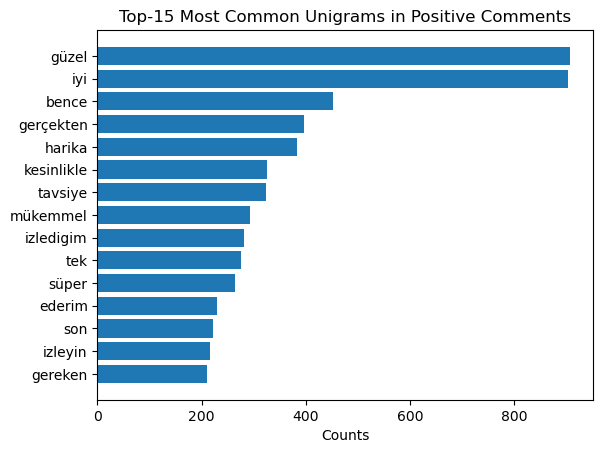

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
ngram = top_15.keys()
y_pos = np.arange(len(ngram))
performance = top_15.values()


ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ngram)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Counts')
ax.set_title('Top-15 Most Common Unigrams in Positive Comments')

plt.show()

### **NEGATIVE CLASS UNIGRAMS**

In [9]:
#for negative sentiments
df_neg=df_train[df_train["Label"]==0]

#for only unigrams
token_list=[]

for i,r in df_neg.iterrows():
    text=''.join(ch for ch in df_neg["comment"][i] if ch not in exclude and ch != "’") #remove punctuations from the text in order not to distort frequencies
    tokens=word_tokenize(text)
    tokens=[tok.lower() for tok in tokens if tok not in stop_words] #remove stopwords from the text in order not to distort frequencies
    token_list.extend(tokens)
    
frequencies=Counter(token_list)
frequencies_sorted=sorted(frequencies.items(), key=lambda k: k[1],reverse=True)
top_15=dict(frequencies_sorted[0:15])

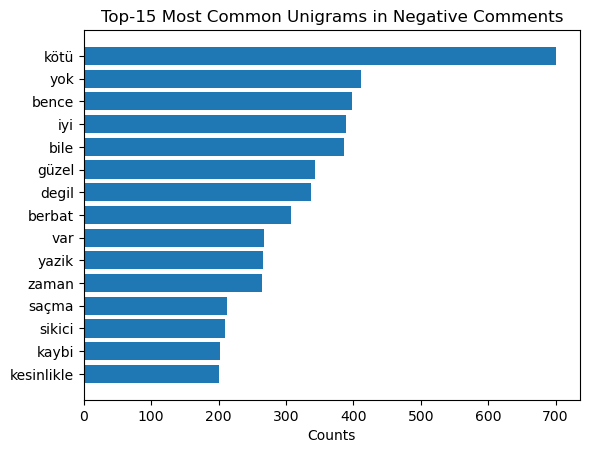

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
ngram = top_15.keys()
y_pos = np.arange(len(ngram))
performance = top_15.values()


ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ngram)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Counts')
ax.set_title('Top-15 Most Common Unigrams in Negative Comments')

plt.show()

Even the majority of common words are quite sensible, when only unigrams are explored, some words does not make sense. For example, "güzel" in Turkish has positive meaning (the most common unigram in the positive comments). However, it is one of the most common (5th one) single word in the negative comments. Therefore, the word before and after "güzel" gains more importance. Let's have a look at the bigrams :) 

### **POSITIVE CLASS BIGRAMS**

In [11]:
from nltk.util import ngrams

token_list=[]

for i,r in df_pos.iterrows():
    text=''.join(ch for ch in df_pos["comment"][i] if ch not in exclude and ch != "’") #remove punctuations from the text in order not to distort frequencies
    tokens=word_tokenize(text)
    tokens=[tok.lower() for tok in tokens if tok not in stop_words] #remove stopwords from the text in order not to distort frequencies 
    token_list.extend(tokens)
    
 
bigrams=list(ngrams(token_list,2))
frequencies=Counter(bigrams)
frequencies_sorted=sorted(frequencies.items(), key=lambda k: k[1],reverse=True)
top_15=dict(frequencies_sorted[0:15])


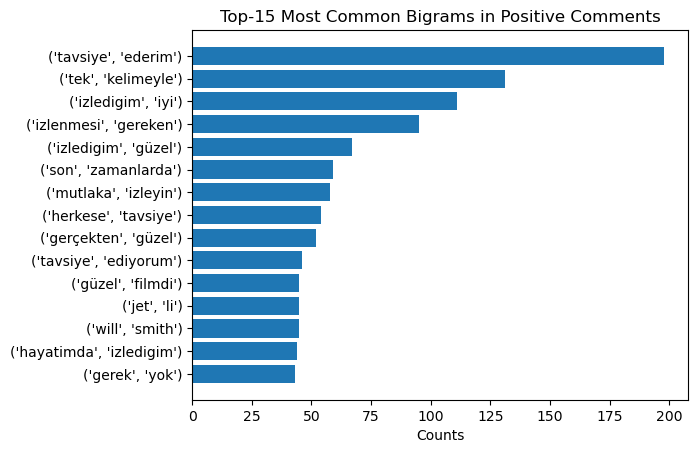

In [12]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
ngram = top_15.keys()
y_pos = np.arange(len(ngram))
performance = top_15.values()


ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ngram)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Counts')
ax.set_title('Top-15 Most Common Bigrams in Positive Comments')

plt.show()

In [13]:
token_list=[]

for i,r in df_neg.iterrows():
    text=''.join(ch for ch in df_neg["comment"][i] if ch not in exclude and ch != "’") #remove punctuations from the text in order not to distort frequencies
    tokens=word_tokenize(text)
    tokens=[tok.lower() for tok in tokens if tok not in stop_words] #remove stopwords from the text in order not to distort frequencies 
    token_list.extend(tokens)
    
 
bigrams=list(ngrams(token_list,2))
frequencies=Counter(bigrams)
frequencies_sorted=sorted(frequencies.items(), key=lambda k: k[1],reverse=True)
top_15=dict(frequencies_sorted[0:15])

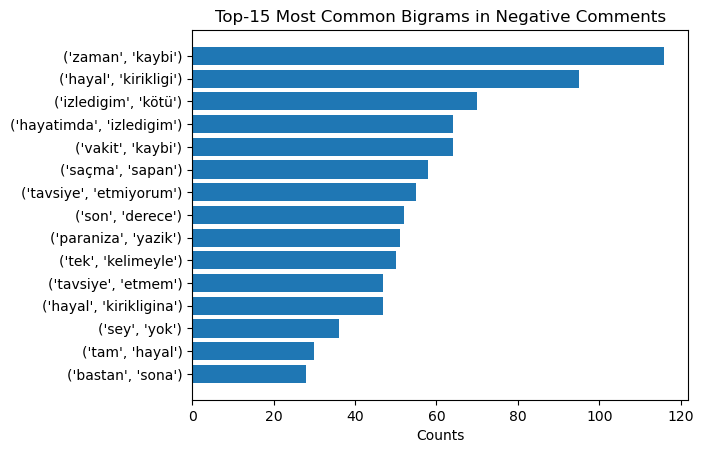

In [14]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
ngram = top_15.keys()
y_pos = np.arange(len(ngram))
performance = top_15.values()


ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ngram)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Counts')
ax.set_title('Top-15 Most Common Bigrams in Negative Comments')

plt.show()

With bigram distributions in each class, the dataset seems to have quite good labels. Let's dive into classification model!

# 2) BERTURK Model Fine Tuning

In [15]:
# Get the comments and their labels from training data as series.
comments = df_train.comment.values
labels = df_train.Label.values

As stated in https://stackoverflow.com/questions/54938815/data-preprocessing-for-nlp-pre-training-models-e-g-elmo-bert, BERT has word piece tokenizer and it magicly helps with dirty data. Therefore, there is no so much need to apply preprocessing steps.


In [16]:
from transformers import AutoTokenizer
#Load BERT Turkish tokenizer
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased",do_lower_case=True)

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils.py:831: FutureWarning: Parameter max_len is deprecated and will be removed in a future release. Use model_max_length instead.
  category=FutureWarning,


Since BERT takes maximum 512 tokens as input, we need to take care of input lengths. To show length of embeddings in the data will be helpful to determine maximum length of comments and padding threshold.

In [17]:

import matplotlib.pyplot as plt
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return

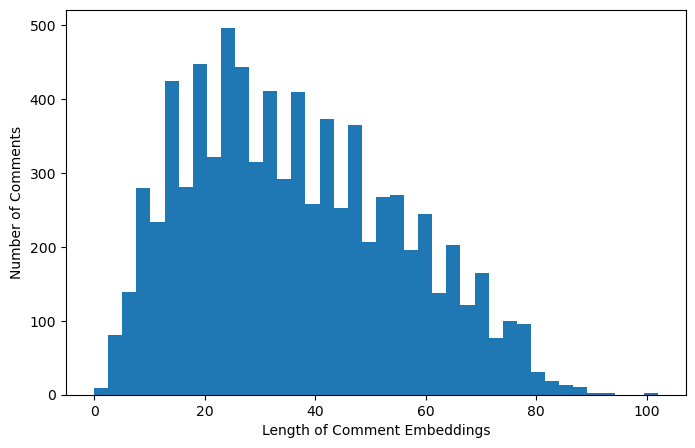

In [18]:
plot_sentence_embeddings_length(comments,tokenizer)

It seems almost all comments have less than 100 tokens, therefore instead of 512, we can set maximum length as 128.

In [19]:
indices=tokenizer.batch_encode_plus(comments,max_length=128,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]
print(input_ids[0])
print(comments[0])

[2, 2834, 2995, 2048, 11936, 2816, 6289, 26704, 7735, 2018, 16491, 4898, 8295, 1009, 12262, 1023, 3525, 18, 18, 2956, 2248, 2067, 4225, 12232, 6152, 3157, 12475, 11921, 2024, 5535, 6147, 1024, 16, 3176, 2473, 2577, 6147, 1024, 16, 5851, 2031, 6147, 1024, 11835, 2881, 2262, 27356, 4432, 6356, 2162, 2628, 22187, 1981, 13448, 10514, 3520, 4345, 83, 2045, 1008, 14668, 1028, 2960, 18, 14921, 7126, 30, 2048, 2142, 2010, 35, 22669, 18, 18, 18, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
biri bana bu filmde benim anlamadigim bisey oldugunu söylesin lütfen.. uzun zamandir bilim kurgu vb tür filmleri izliyorum basit olanlari,mantiksiz olanlari,hatali olanlari gördüm ama böylesine rastlamadim saçma filmler kategorisinde kesin bi ödül alir film.kisaca:bu ne ya? diyorsunuz.. . 



In [20]:
from sklearn.model_selection import train_test_split

# Use 99% for training and 1% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.2)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

In [21]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [22]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [23]:
from transformers import AutoModelForSequenceClassification, AdamW, AutoConfig
config = AutoConfig.from_pretrained(
        "dbmdz/bert-base-turkish-cased",num_labels=2)
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = AutoModelForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-cased",config=config)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [24]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  betas=[0.9,0.999],
                  eps = 1e-6 # args.adam_epsilon  - default is 1e-8.
                )
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [25]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [26]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [27]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 30 batches.
        if step % 30 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...
  Batch    30  of    200.    Elapsed: 0:00:12.
  Batch    60  of    200.    Elapsed: 0:00:24.
  Batch    90  of    200.    Elapsed: 0:00:35.
  Batch   120  of    200.    Elapsed: 0:00:47.
  Batch   150  of    200.    Elapsed: 0:00:58.
  Batch   180  of    200.    Elapsed: 0:01:10.

  Average training loss: 0.38
  Training epoch took: 0:01:17

Running Validation...
  Accuracy: 0.91
  Validation took: 0:00:06

======== Epoch 2 / 5 ========
Training...
  Batch    30  of    200.    Elapsed: 0:00:11.
  Batch    60  of    200.    Elapsed: 0:00:23.
  Batch    90  of    200.    Elapsed: 0:00:34.
  Batch   120  of    200.    Elapsed: 0:00:46.
  Batch   150  of    200.    Elapsed: 0:00:57.
  Batch   180  of    200.    Elapsed: 0:01:09.

  Average training loss: 0.18
  Training epoch took: 0:01:16

Running Validation...
  Accuracy: 0.93
  Validation took: 0:00:06

======== Epoch 3 / 5 ========
Training...
  Batch    30  of    200.    Elapsed: 0:00:11.
  

# 3) BERTurk Model Performance on Test Set 

In [28]:
# Create sentence and label lists for test data
comments1 = df_test.comment.values
labels1 = df_test.Label.values

indices1=tokenizer.batch_encode_plus(comments1,max_length=128,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
input_ids1=indices1["input_ids"]
attention_masks1=indices1["attention_mask"]

prediction_inputs1= torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)
prediction_labels1 = torch.tensor(labels1)

# Set the batch size.  
batch_size = 32 

# Create the DataLoader.
prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1, prediction_labels1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size)

In [29]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs1)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader1:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids1, b_input_mask1, b_labels1 = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs1 = model(b_input_ids1, token_type_ids=None, 
                      attention_mask=b_input_mask1)

  logits1 = outputs1[0]

  # Move logits and labels to CPU
  logits1 = logits1.detach().cpu().numpy()
  label_ids1 = b_labels1.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits1)
  true_labels.append(label_ids1)

print('    DONE.')

Predicting labels for 2,666 test sentences...
    DONE.


In [30]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [31]:
from sklearn.metrics import accuracy_score
print("Accuracy of BERT is:",accuracy_score(flat_true_labels, flat_predictions))

Accuracy of BERT is: 0.9343585896474118


In [32]:
from sklearn.metrics import classification_report
print(classification_report(flat_true_labels, flat_predictions))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93      1333
           1       0.93      0.94      0.93      1333

    accuracy                           0.93      2666
   macro avg       0.93      0.93      0.93      2666
weighted avg       0.93      0.93      0.93      2666



### **We reach 93% accuracy score on this highly balanced dataset even without hyperparameter optimization with BERTURK base model. For comparison, ULMFit pretrained language model based on LSTMs which is develoed by fastai team, has [91% accuracy score](https://github.com/fastai/course-nlp/blob/master/nn-turkish.ipynb) in this dataset. Also, Gezici (2018), *Sentiment Analysis in Turkish* has 75%.**

### If you like this network, feel free to UPVOTE :) 